# Section 0: Importing libraries

In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from statsmodels.stats import diagnostic

# Section 1: Data pre-processing
---
(fix broken links and add numbers)
[Loading the data](#loading-the-data) \
[Dataset properties](#data-properties)

### Loading the data

In [2]:
# main data path and relative paths to the datasets
DATA_PATH = "./data/"
DATA_PATH_MOVIESUMMARIES = DATA_PATH + "MovieSummaries/"
DATA_PATH_MOVIELENS = DATA_PATH + "MovieLens/"
DATA_PATH_IMDB = DATA_PATH + "IMDBData/"
DATASET_PATH = {
    "movie_metadata": DATA_PATH_MOVIESUMMARIES + "movie.metadata.tsv",
    "movie_budget": DATA_PATH_MOVIELENS + "movies_metadata.csv",
    "imdb_ratings": DATA_PATH_IMDB + "title.ratings.tsv",
    "imdb_basics": DATA_PATH_IMDB + "title.basics.tsv",
}
DATASET_COLUMNS = {
    "movie_metadata": [
        "wikipedia_id",
        "freebase_movie_id",
        "title",
        "release_date",
        "revenue",
        "runtime",
        "languages",
        "countries",
        "genres",
    ],
    "movie_budget": [
        "budget",
        "imdb_id",
        "original_title",
        "popularity",
        "release_date",
        "revenue",
        "runtime",
        "title",
        "vote_average",
        "vote_count",
    ],
    "imdb_ratings": ["imdb_id", "imdb_rating", "num_votes"],
    "imdb_basics": [
        "imdb_id",
        "title_type",
        "primary_title",
        "title",
        "is_adult",
        "year",
        "end_year",
        "runtime",
        "genres",
    ],
}

TODO: Add dtypes for all datasets

In [3]:
DATASET_TYPES = {
    "movie_metadata": {
        "wikipedia_id": "string",
        "freebase_movie_id": "string",
        "title": "string",
        "release_date": "string",
        "revenue": "float64",
        "runtime": "string",
        "languages": "object",
        "countries": "object",
        "genres": "object",
    },
    "movie_budget": {
        "budget": "object",
        "imdb_id": "string",
        "original_title": "object",
        "popularity": "object",
        "release_date": "object",
        "revenue": "float64",
        "runtime": "string",
        "title": "object",
        "vote_average": "float64",
        "vote_count": "float64",
    },
    "imdb_ratings": {
        "imdb_id": "string",
        "imdb_rating": "float64",
        "num_votes": "int64",
    },
    "imdb_basics": {
        "imdb_id": "string",
        "title_type": "string",
        "primary_title": "string",
        "title": "string",
        "is_adult": "string",
        "year": "string",
        "end_year": "string",
        "runtime": "string",
        "genres": "string",
    },
}

In [4]:
# load the datasets as pandas dataframes
movie_metadata = pd.read_csv(
    DATASET_PATH["movie_metadata"],
    sep="\t",
    names=DATASET_COLUMNS["movie_metadata"],
    index_col=False,
    header=None,
    dtype=DATASET_TYPES["movie_metadata"],
)
movie_budget = pd.read_csv(
    DATASET_PATH["movie_budget"],
    sep=",",
    usecols=DATASET_COLUMNS["movie_budget"],
    index_col=False,
    header=0,
    dtype=DATASET_TYPES["movie_budget"],
)
imdb_ratings = pd.read_csv(
    DATASET_PATH["imdb_ratings"],
    sep="\t",
    names=DATASET_COLUMNS["imdb_ratings"],
    index_col=False,
    header=0,
    dtype=DATASET_TYPES["imdb_ratings"],
)
imdb_basics = pd.read_csv(
    DATASET_PATH["imdb_basics"],
    sep="\t",
    names=DATASET_COLUMNS["imdb_basics"],
    index_col=False,
    header=0,
    dtype=DATASET_TYPES["imdb_basics"],
)

### Dataset overview

In [5]:
# Print the shapes of the datasets
print("Movie Metadata Shape: ", movie_metadata.shape)
print("MovieLens Budget Shape: ", movie_budget.shape)
print("IMDB Ratings Shape: ", imdb_ratings.shape)
print("IMDB Basics Shape: ", imdb_basics.shape)

Movie Metadata Shape:  (81741, 9)
MovieLens Budget Shape:  (45466, 10)
IMDB Ratings Shape:  (1368131, 3)
IMDB Basics Shape:  (10309011, 9)


Below we show a sample from each dataframe to get a feel for the data:

In [6]:
movie_metadata.sample(1)

,wikipedia_id,freebase_movie_id,title,release_date,revenue,runtime,languages,countries,genres
77860,5123642,/m/0d3rr9,Never Cry Wolf,1983-10-07,27668764.0,91.0,"{""/m/0322q8"": ""Inuktitut"", ""/m/02h40lc"": ""Engl...","{""/m/09c7w0"": ""United States of America""}","{""/m/03btsm8"": ""Action/Adventure"", ""/m/0hj3mtj..."


In [7]:
movie_budget.sample(1)

,budget,imdb_id,original_title,popularity,release_date,revenue,runtime,title,vote_average,vote_count
19006,0,tt1753995,친구사이?,0.239151,2009-12-17,0.0,29.0,Just Friends?,6.5,4.0


In [8]:
imdb_ratings.sample(1)

,imdb_id,imdb_rating,num_votes
240057,tt0438255,8.0,6


In [9]:
imdb_basics.sample(1)

,imdb_id,title_type,primary_title,title,is_adult,year,end_year,runtime,genres
6660068,tt27813267,tvSeries,Le château de mes rêves,Le château de mes rêves,0,2022,\N,52,Reality-TV


#### Data Handling

---
##### Dataset: `movie_metadata`

In [10]:
print("Total amount of rows that contain a NaN value: ", movie_metadata.isna().any(axis=1).sum())
pd.DataFrame({'nan_sum': movie_metadata.isna().sum(), 'nan_percentage': movie_metadata.isna().mean() * 100})

Total amount of rows that contain a NaN value:  73498


,nan_sum,nan_percentage
wikipedia_id,0,0.000000
freebase_movie_id,0,0.000000
title,0,0.000000
release_date,6902,8.443743
revenue,73340,89.722416
runtime,20450,25.018045
languages,0,0.000000
countries,0,0.000000
genres,0,0.000000


This shows that some of the rows that contain NaN values could also be overlapping. We will drop all rows that contain NaN values in order to be able to properly merge to the corresponding external datasets. 

In [11]:
# find the percentage of the dataframe reduction after dropping NaNs
original_rows = movie_metadata.shape[0]
print("Number of movies before dropping NaNs:", original_rows)
movie_metadata = movie_metadata.dropna()
print("Number of movies after dropping NaNs:", movie_metadata.shape[0])
print("The dataset shrinked by {:.2f}%".format((original_rows - movie_metadata.shape[0]) / original_rows * 100))

Number of movies before dropping NaNs: 81741
Number of movies after dropping NaNs: 8243
The dataset shrinked by 89.92%


It is important to also check if there are movies with a revenue of value 0 as it has an equal meaning and impact as NaNs in our scenario. Movies that have 0 revenue, means that they have missing (or did not generate) any revenue. We will drop these movies as well (if any).

In [12]:
# find if there are any movies with 0 revenue
print("Number of movies with 0 revenue:", movie_metadata[movie_metadata["revenue"] == 0].shape[0])

Number of movies with 0 revenue: 0


In order to be able to merge the datasets, we need to do some small adjustments to some of the features of the current dataset. Particularly, from all values in `release_date` we will extract the release year and store it in a new column `year` as dates do not all follow the same format, but they all contain the release year.

In [13]:
# runtime was converted from float to string, so the substring ".0" needs to be removed
movie_metadata["runtime"] = movie_metadata["runtime"].astype(str).str.replace(".0", "", regex=False)

# make a column year extracting the year from the release date
movie_metadata["year"] = movie_metadata["release_date"].str[:4]

movie_metadata.sample(1)

,wikipedia_id,freebase_movie_id,title,release_date,revenue,runtime,languages,countries,genres,year
51022,10296498,/m/02q7q1w,The Nutcracker Prince,1990-11-21,1781694.0,75,"{""/m/02h40lc"": ""English Language""}","{""/m/0d060g"": ""Canada""}","{""/m/03k9fj"": ""Adventure"", ""/m/0hj3myq"": ""Chil...",1990


We also need to check if all duplicate movies have been removed. We do this by checking if the `wikipedia_id` column contains only unique values. Since we will later on merge on the columns `title`, `year` and `runtime` with the external datasets, we will also check if there are any duplicate values by combining these columns.

In [14]:
# check if wikipedia_id contains duplicated values
print("Number of duplicated wikipedia_id values:", movie_metadata["wikipedia_id"].duplicated().sum())

# check if title, year and runtime combined contain duplicated values
print(
    "Number of duplicated title, year and runtime combined values:",
    movie_metadata[["title", "year", "runtime"]].duplicated().sum(),
)

Number of duplicated wikipedia_id values: 0
Number of duplicated title, year and runtime combined values: 0


Now that we have cleaned the initial movie dataset, we can perform some basic analysis on the data and explore further the ways we can enrich it with external datasets.

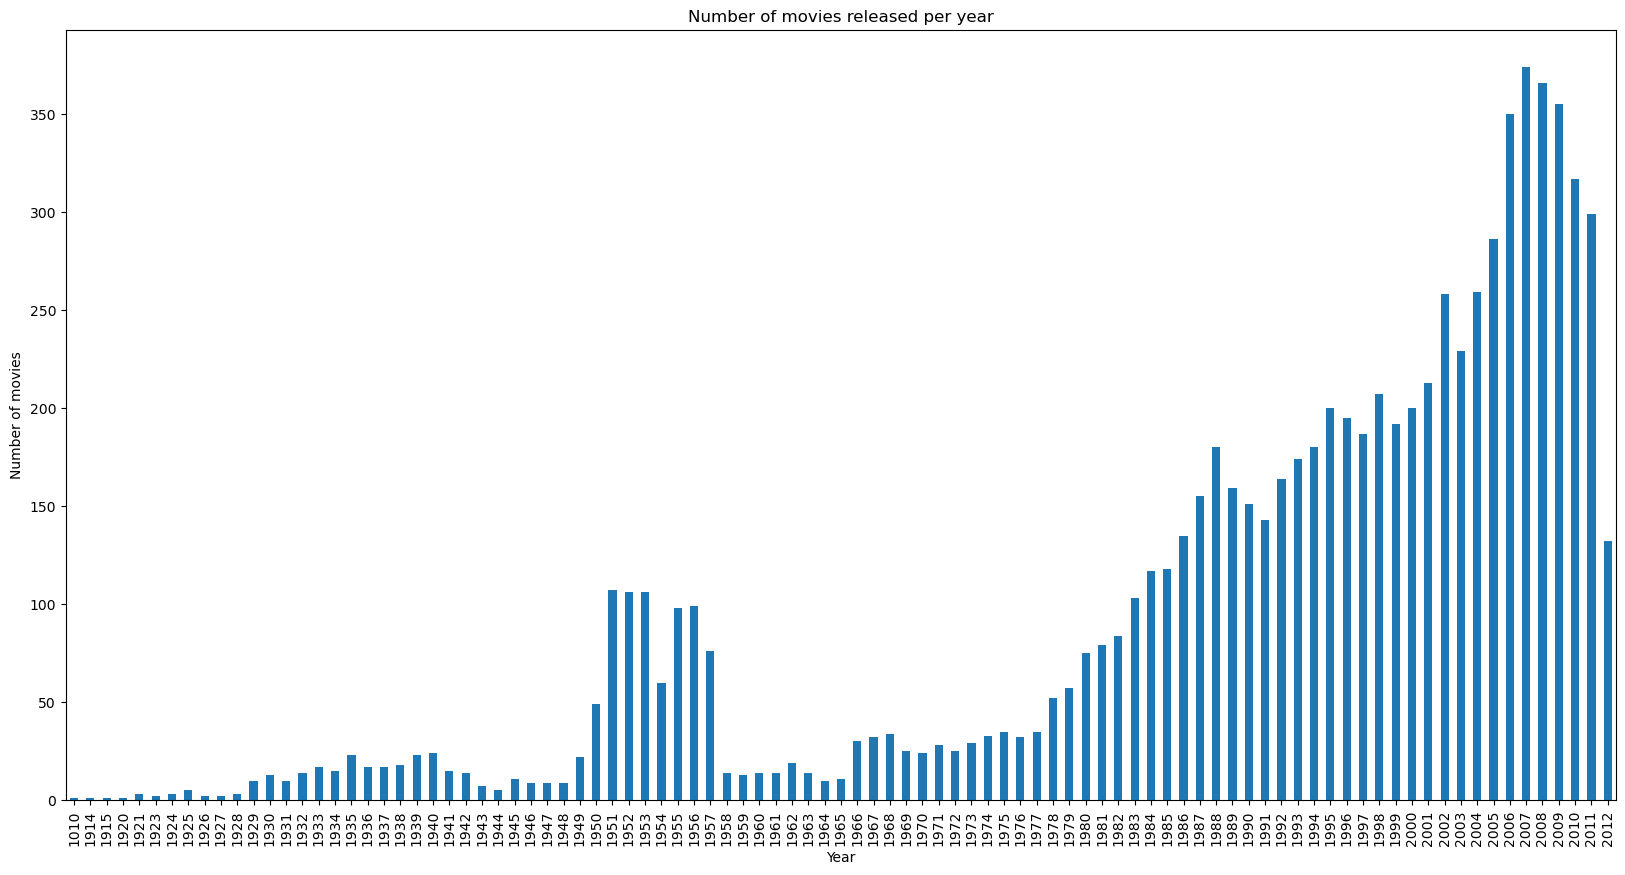

In [15]:
# plot number of movies released per year
movie_metadata["year"].value_counts().sort_index().plot(kind="bar", figsize=(20, 10))
plt.title("Number of movies released per year")
plt.xlabel("Year")
plt.ylabel("Number of movies")
plt.show()

We can see that the number of movies released per year has been increasing over the years. This is expected as the movie industry has been growing and expanding over the years. We can also see that there is a significant increase in the number of movies released after 2000. This could be due to the fact that the dataset contains more recent movies than older ones.

---
##### Dataset: `movie_budget`
With this external dataset, we aim to also append the budget of the movies to our main movie dataset. This would help us to better understand the correlation between the budget and the revenue of the movies and explore the profitability of the movies.



We follow a similar procedure for data preprocessing and cleaning as previously. We first check for NaN values and drop them if any.

In [16]:
# 
movie_budget = movie_budget.replace("\\N", np.nan)
pd.DataFrame({'nan_sum': movie_budget.isna().sum(), 'nan_percentage': movie_budget.isna().mean() * 100})

,nan_sum,nan_percentage
budget,0,0.000000
imdb_id,17,0.037391
original_title,0,0.000000
popularity,5,0.010997
release_date,87,0.191352
revenue,6,0.013197
runtime,263,0.578454
title,6,0.013197
vote_average,6,0.013197
vote_count,6,0.013197


In [17]:
movie_budget = movie_budget.dropna()

In [18]:
movie_budget.drop_duplicates(subset="imdb_id", inplace=True)

IMDB

In [19]:
imdb_ratings = imdb_ratings.replace("\\N", np.nan)
pd.DataFrame({'nan_sum': imdb_ratings.isna().sum(), 'nan_percentage': imdb_ratings.isna().mean() * 100})

,nan_sum,nan_percentage
imdb_id,0,0.0
imdb_rating,0,0.0
num_votes,0,0.0


In [20]:
imdb_basics = imdb_basics.replace("\\N", np.nan)
pd.DataFrame({'nan_sum': imdb_basics.isna().sum(), 'nan_percentage': imdb_basics.isna().mean() * 100})

,nan_sum,nan_percentage
imdb_id,0,0.000000
title_type,0,0.000000
primary_title,11,0.000107
title,11,0.000107
is_adult,1,0.000010
year,1381604,13.401906
end_year,10194381,98.888060
runtime,7203485,69.875617
genres,460237,4.464415


In [21]:
imdb_basics = imdb_basics.drop(columns=["end_year"])

In [22]:
imdb_basics.dropna(subset=["year", "title", "runtime"], inplace=True)

In [23]:
pd.DataFrame({'nan_sum': imdb_basics.isna().sum(), 'nan_percentage': imdb_basics.isna().mean() * 100})

,nan_sum,nan_percentage
imdb_id,0,0.000000
title_type,0,0.000000
primary_title,0,0.000000
title,0,0.000000
is_adult,0,0.000000
year,0,0.000000
runtime,0,0.000000
genres,77146,2.651581


In [24]:
imdb_dataset_temp = pd.merge(imdb_basics, imdb_ratings, on="imdb_id", how="left")
imdb_dataset = pd.merge(
    imdb_dataset_temp,
    movie_budget,
    on="imdb_id",
    how="left",
    suffixes=("", "_movie_budget"),
)

In [25]:
imdb_dataset.head()

,imdb_id,title_type,primary_title,title,is_adult,year,runtime,genres,imdb_rating,num_votes,budget,original_title,popularity,release_date,revenue,runtime_movie_budget,title_movie_budget,vote_average,vote_count
0,tt0000001,short,Carmencita,Carmencita,0,1894,1,"Documentary,Short",5.7,2007.0,0,Carmencita,1.273072,1894-03-14,0.0,1.0,Carmencita,4.9,18.0
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,5,"Animation,Short",5.8,269.0,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,4,"Animation,Comedy,Romance",6.5,1909.0,0,Pauvre Pierrot,0.673164,1892-10-28,0.0,4.0,Poor Pierrot,6.1,19.0
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,12,"Animation,Short",5.5,178.0,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,1,"Comedy,Short",6.2,2691.0,0,Blacksmith Scene,1.061591,1893-05-08,0.0,1.0,Blacksmith Scene,5.8,19.0


In [26]:
imdb_dataset = imdb_dataset.loc[
    :, ~imdb_dataset.columns.str.endswith("_movie_budget")
]  # keep only the columns from the imdb dataset

In [27]:
imdb_dataset.shape

(2909434, 17)

In [80]:
movies_merged = pd.merge(
    movie_metadata,
    imdb_dataset,
    on=["title", "year", "runtime"],
    how="left",
)

In [81]:
movies_merged.sample(1)

,wikipedia_id,freebase_movie_id,title,release_date_x,revenue_x,runtime,languages,countries,genres_x,year,...,genres_y,imdb_rating,num_votes,budget,original_title,popularity,release_date_y,revenue_y,vote_average,vote_count
7365,4894733,/m/0cs_w9,The Fourth Protocol,1987,12423831.0,118,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0cq22f9"": ""Actio...",1987,...,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [82]:
# TODO: fix the dtypes, drop unnecessary columns (maybe even better at import time)
movies_merged.dtypes

wikipedia_id          string
freebase_movie_id     string
title                 string
release_date_x        string
revenue_x            float64
runtime               object
languages             object
countries             object
genres_x              object
year                  string
imdb_id               string
title_type            string
primary_title         string
is_adult              string
genres_y              string
imdb_rating          float64
num_votes            float64
budget                object
original_title        object
popularity            object
release_date_y        object
revenue_y            float64
vote_average         float64
vote_count           float64
dtype: object

In [83]:
# switch dtype of budget to float
movies_merged["budget"] = movies_merged["budget"].astype(float)

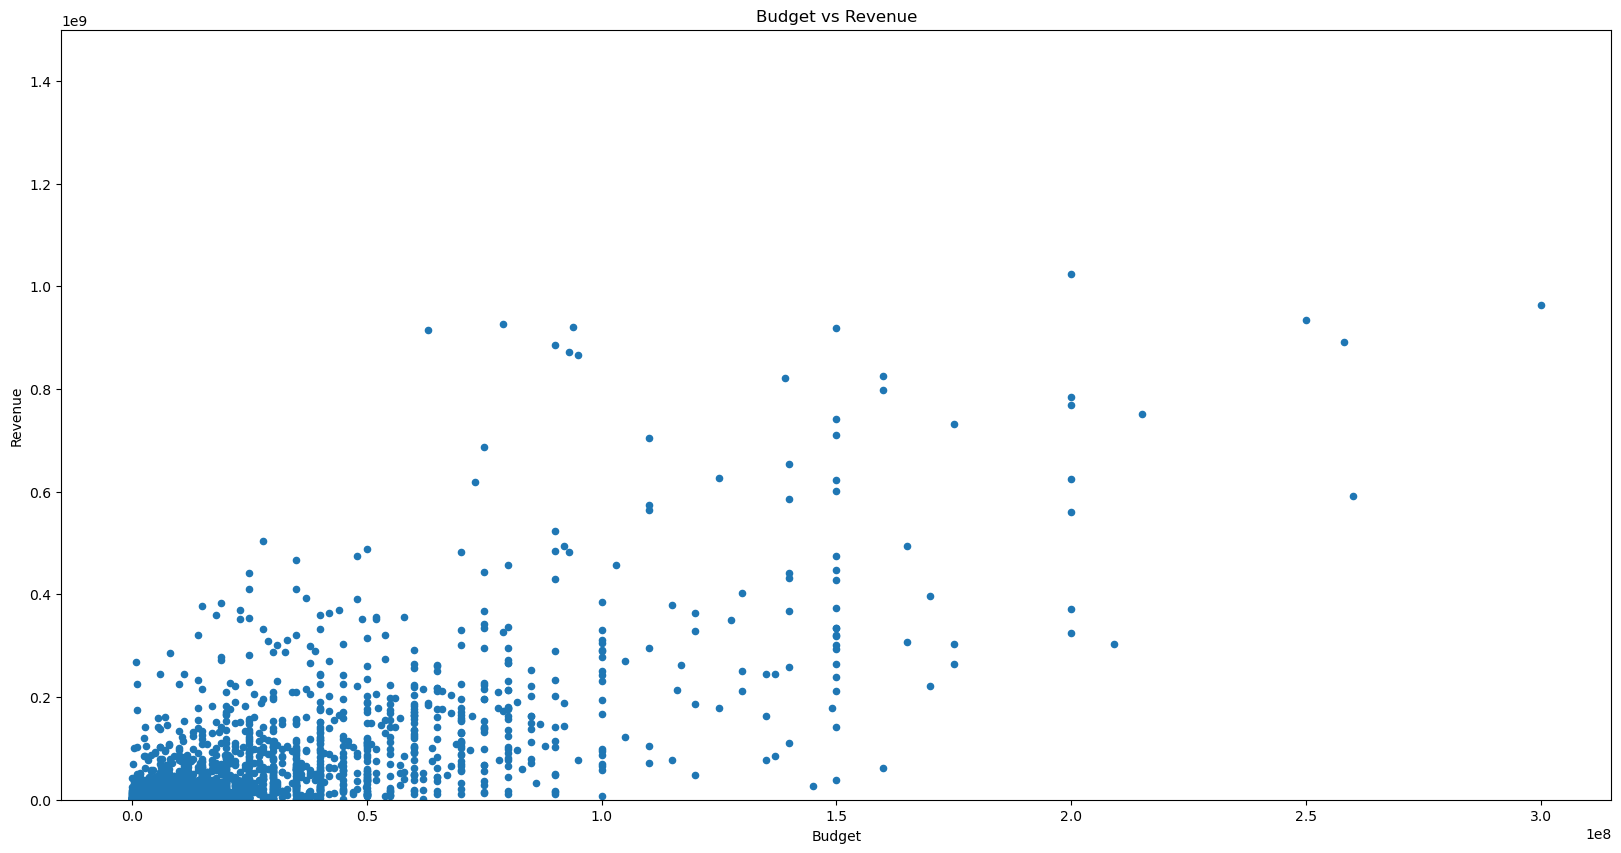

In [84]:
# scatter plot between budget > 0 and revenue
movies_merged[movies_merged["budget"] > 0].plot.scatter(
    x="budget", y="revenue_x", figsize=(20, 10)
)
plt.title("Budget vs Revenue")
plt.xlabel("Budget")
plt.ylabel("Revenue")
# limit y to 1.5 to remove outlier and have better representation of the data
plt.ylim(0, 1.5 * 1e9)
plt.show()

In [85]:
# Check if budget and revenue are correlated with pearson correlation coefficient
budget_revenue_stats_p = stats.pearsonr(
    movies_merged[movies_merged["budget"] > 0]["budget"],
    movies_merged[movies_merged["budget"] > 0]["revenue_x"])
print(budget_revenue_stats_p)

budget_revenue_stats_s = stats.spearmanr(
    movies_merged[movies_merged["budget"] > 0]["budget"],
    movies_merged[movies_merged["budget"] > 0]["revenue_x"])
print(budget_revenue_stats_s)

PearsonRResult(statistic=0.686527149370736, pvalue=1.5343438100764493e-256)
SignificanceResult(statistic=0.6592064061806329, pvalue=1.0529351531182339e-229)


Conducting both Pearson and Spearman statistics, we notice that the relationship between `budget` and `revenue`, for those movie entries where `budget < 0` is significant and strong (roughly 0.65)

TODO: Do we care about inflation when comparing budget and revenue? I think not as we are not comparing the actual values, but the relationship between them.

What movie genres have the highest budget? Are these the same as the ones with the highest revenue?

In [86]:
from collections import Counter
import ast
#TODO: Check if can fix the dtype in advance to load genres as dict instead of string

# transform the string of genres to a dict of genres
movies_merged["genres_x"] = movies_merged["genres_x"].apply(lambda x: ast.literal_eval(x))

In [106]:
genre_counter = Counter(genre for genres in movies_merged["genres_x"] for genre in genres.values())

In [103]:
# budget
top_10_genres = genre_counter.most_common(5)
top_10_genres_budget = {}
for genre in top_10_genres:
    top_10_genres_budget[genre[0]] = movies_merged[movies_merged["genres_x"].apply(lambda x: genre[0] in x.values())]["budget"].mean()

# revenue
top_10_genres_revenue = {}
for genre in top_10_genres:
    top_10_genres_revenue[genre[0]] = movies_merged[movies_merged["genres_x"].apply(lambda x: genre[0] in x.values())]["revenue_x"].mean()

top_10_genres_df = pd.DataFrame.from_dict(top_10_genres_budget, orient="index", columns=["avg_budget"])
top_10_genres_df["avg_revenue"] = top_10_genres_revenue.values()
top_10_genres_df

,avg_budget,avg_revenue
Drama,1.426029e+07,4.002168e+07
Comedy,1.690536e+07,5.067283e+07
Romance Film,1.334103e+07,4.416072e+07
Thriller,2.691257e+07,7.064535e+07
Action,3.197183e+07,8.902345e+07


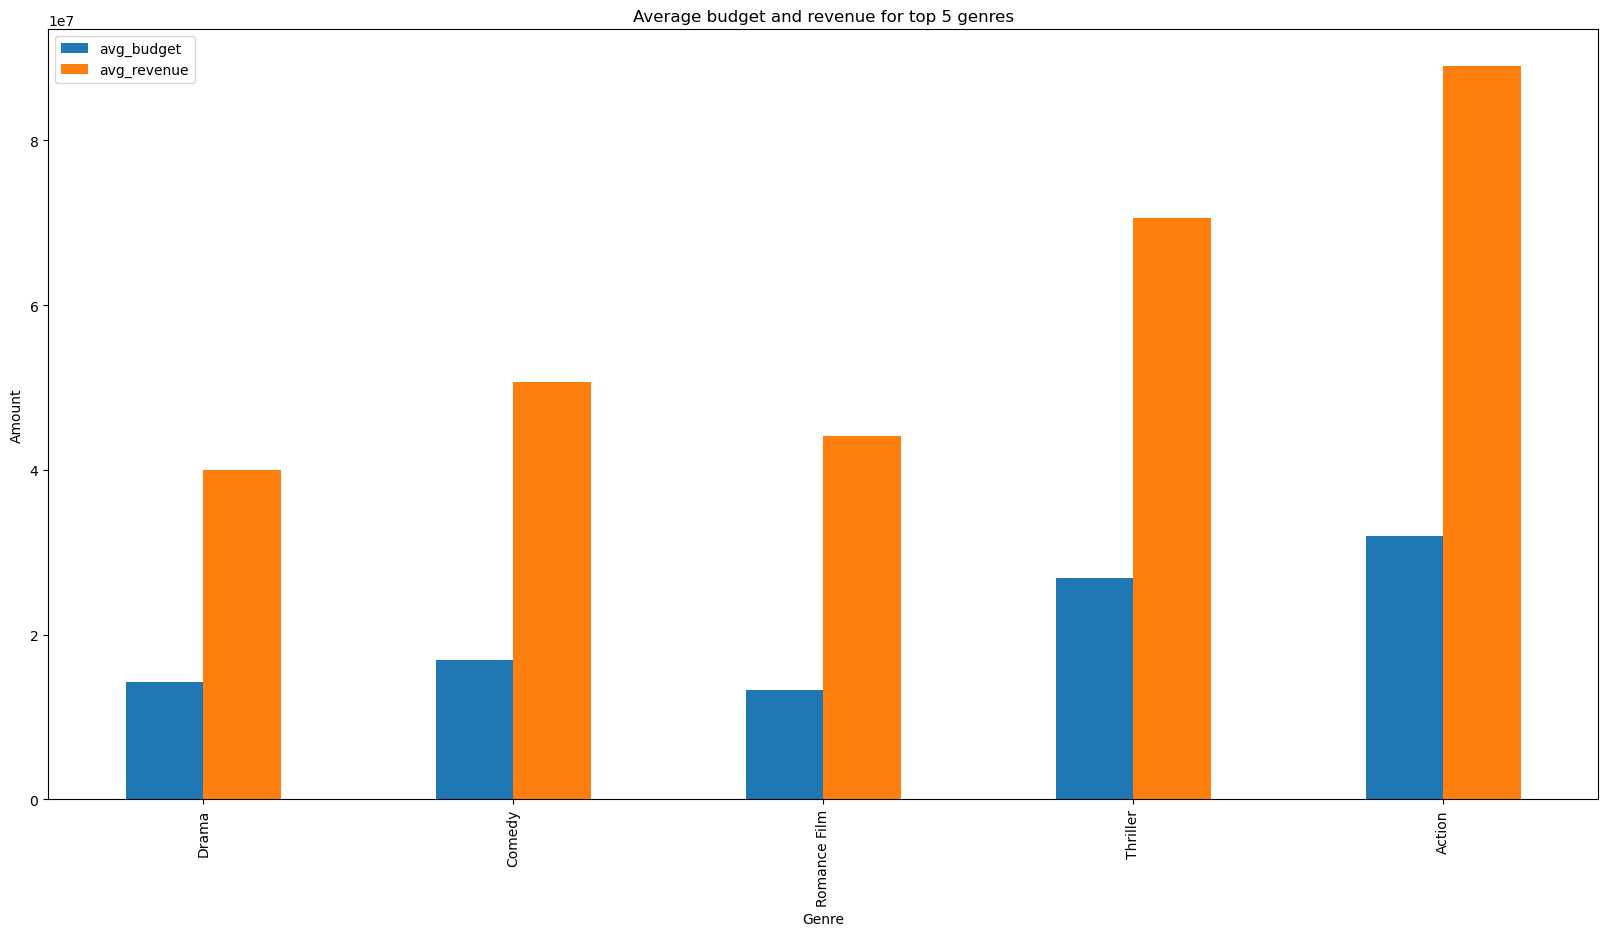

In [105]:
# plot the average budget and revenue per genre
top_10_genres_df.plot.bar(figsize=(20, 10))
plt.title("Average budget and revenue for top 5 genres")
plt.xlabel("Genre")
plt.ylabel("Amount")
plt.show()